# Graph isomorphism

Ising formulation here: https://arxiv.org/abs/1302.5843 (Lucas 2014)

Lets assume that we have two directed graphs $G_1 = (V_1, E_1)$ and $G_2 = (V_2, E_2)$. They are isomorphic if we can find bijection from $V_1$ to $V_2$ so that structure of mapped $V_1$ is identical to $V_2$. Obviously $n=|V_1|=|V_2|$. 

One obvious solution is binary variable vector having $|V||V|$ elements. Each element indicate a mapping from one vertex to the other (Lucas 2014). To achieve the results intended, following constraints are build to QUBO:
1. every vertex $v_1 \in G_1$ must be mapped to some vertex $v_3 \in G_2$ (penalty $p$ for every couple of vertices which are indicated to be mappings from the same source)  
2. every vertex $v_2 \in G_2$ must be mapped from some vertex $v_1 \in G_1$ (penalty $p$ for every couple of vertices which are indicated to be mapped to the same target) 
3. for every $e_1 \in E_1$  there should be counterpart $e_2 \in E_2$ so that with mapping $e_1$ starting and ending vertex there are similar $e_2$. Each succesfull mapping brings gain of $-1$. 

If graphs are isomorphic, lowest energy level is $-|E|$. This comes from third constraint of the QUBO. Binary variable vector of this energy level shows correct mapping.  

Main disadvantage of this algorithm is fast growing elements in binary variable vector when number of vertices increases (size of vector is $|V|^2$). Size of QUBO grows even faster, as size of the QUBO is $|V|^4$.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler
import dwave.inspector
import networkx as nx
from networkx.classes.function import path_weight
import random

## QUBO function

In [2]:
def create_qubo(E1,E2,vertices,p):
    Q = np.zeros((vertices*vertices, vertices*vertices))
    
    # Constraint 1: penalty if several mappings from same source
    for i in range(vertices): 
        for j in range(vertices): 
            for k in range(j+1,vertices): 
                Q[i*vertices+j,i*vertices+k]=p 

    # Constaint 2: penalty if several mappings to same target
    for i in range(vertices): 
        for j in range(vertices): 
            for k in range(j+1,vertices): 
                Q[i+vertices*j,i+vertices*k]=p 
                
    # Constraint 3: -1 for each succesfully mapped edge: (x1,y1) -> (x2,y2) 
    #    two possible mappings: (x1->x2, y1->y2) or (x1->y2,y1->x2)
    for e1 in E1: 
        for e2 in E2: 
            Q[e1[0]*vertices+e2[0], e1[1]*vertices+e2[1]] -= 1
            Q[e1[0]*vertices+e2[1], e1[1]*vertices+e2[0]] -= 1
            
    # All quadratic coefficients in lower triangle to upper triangle
    for i in range(vertices*vertices): 
        for j in range(i):
            Q[j,i] += Q[i,j]
            Q[i,j] = 0
    return Q

## Helper functions

In [3]:
def result_info(sampleset, e):
    print('Lowest energy should be:',-e)
    print('Lowest energy was:',int(sampleset.first.energy))
    results = []
    if -e!=int(sampleset.first.energy):
        print('Graphs are NOT isomorphic')
    else:
        print('Graphs are isomorphic')
        for sample in sampleset:
            m = ''
            res = {}
            for k,v in sample.items():
                if v==1:
                    m += str(k)+', '
                    res[k[0]]=k[1]
            print('Mapping: '+m)
            results.append(res)
    return results
    
def solve_gi(solver, num_reads, E1, E2, vertices, p, qpu_info=False, qpu_info_hybrid=False, timing_info=False, print_sample=False):
    Q = create_qubo(E1,E2,vertices,p)

    labels = {}
    for i in range(vertices):
        for j in range(vertices):
            labels[i*vertices+j] = (i,j)
        
    bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
    bqm = bqm.relabel_variables(labels, inplace=False)
    t1 = time.time()
    if num_reads==None:
        sampleset = solver.sample(bqm).aggregate()
    else:
        sampleset = solver.sample(bqm, num_reads=num_reads).aggregate()
    ttime = (time.time()-t1)*1000
    if print_sample:
        print(sampleset.truncate(10))
    res = result_info(sampleset.filter(lambda s: s.energy==sampleset.first.energy), len(E1))
    if qpu_info_hybrid:
        print('\nTotal time used (ms): {:.3f}'.format(ttime))
        print('Number of logical qubits:',Q.shape[0])
        print('Number of couplers:', len(bqm.quadratic))
        hyb_time = sampleset.info['qpu_access_time'] / 1000
        run_time = sampleset.info['run_time'] / 1000
        print('QPU time used (ms): {:.1f}'.format(hyb_time))
        print('Total time used (ms): {:.1f}\n'.format(run_time))
    if qpu_info:
        print('\nTotal time used (ms): {:.3f}'.format(ttime))
        print('Number of logical qubits:',Q.shape[0])
        print('Number of couplers:', len(bqm.quadratic))
        qpu_time = sampleset.info['timing']['qpu_access_time'] / 1000
        qubits = sum(len(x) for x in sampleset.info['embedding_context']['embedding'].values())
        print('QPU time used (ms): {:.1f}'.format(qpu_time))
        print('Physical qubits used: {}\n'.format(qubits))
    if timing_info:
        print('\nTotal time used (ms): {:.3f}'.format(ttime))

    return res, sampleset

## First test

Very simple graph from (Calude 2017)

In [4]:
vertices = 3
E1 = np.array([(0, 1), (1, 2)])
E2 = np.array([(0, 1), (0, 2)])
# Correct mapping (0,1),(1,0),(2,2) and (0,2),(1,0),(2,1)
Q = create_qubo(E1,E2,3,2)
print(Q)
print('\n')
bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
sampleset = dimod.ExactSolver().sample(bqm)
print(sampleset.truncate(10))
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 1000, E1, E2, vertices, len(E1))

[[ 0.  2.  2.  2. -1. -1.  2.  0.  0.]
 [ 0.  0.  2. -1.  2.  0.  0.  2.  0.]
 [ 0.  0.  0. -1.  0.  2.  0.  0.  2.]
 [ 0.  0.  0.  0.  2.  2.  2. -1. -1.]
 [ 0.  0.  0.  0.  0.  2. -1.  2.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


   0  1  2  3  4  5  6  7  8 energy num_oc.
0  0  1  0  1  0  0  0  0  1   -2.0       1
1  0  0  1  1  0  0  0  1  0   -2.0       1
2  1  0  0  0  0  1  0  1  0   -1.0       1
3  1  0  0  0  0  1  0  0  0   -1.0       1
4  0  0  0  1  0  0  0  1  0   -1.0       1
5  0  0  0  0  1  0  1  0  0   -1.0       1
6  0  1  0  1  0  0  0  0  0   -1.0       1
7  0  0  1  0  1  0  1  0  0   -1.0       1
8  0  1  0  0  0  1  1  0  0   -1.0       1
9  0  0  0  0  0  1  1  0  0   -1.0       1
['BINARY', 10 rows, 10 samples, 9 variables]
Lowest energy should be: -2
Lowest energy was: -2
Graphs are isomorphic
Mapping: (0, 2), (1, 0), (2, 1), 
Mapping: (0

In [5]:
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 1000, E1, E2, vertices, len(E1))

Lowest energy should be: -2
Lowest energy was: -2
Graphs are isomorphic
Mapping: (0, 2), (1, 0), (2, 1), 
Mapping: (0, 1), (1, 0), (2, 2), 


In [6]:
machine = DWaveSampler(solver={'chip_id': 'Advantage_system6.3'})
print('Chip:', machine.properties['chip_id'])
print('Qubits:', machine.properties['num_qubits'])
res, sampleset = solve_gi(EmbeddingComposite(machine), 1000, E1, E2, vertices, len(E1))

Chip: Advantage_system6.3
Qubits: 5760
Lowest energy should be: -2
Lowest energy was: -2
Graphs are isomorphic
Mapping: (0, 1), (1, 0), (2, 2), 
Mapping: (0, 2), (1, 0), (2, 1), 


## Simple graphs

In [8]:
vertices = 7
E1 = np.array([(0, 1), (0, 2), (0, 3), (2, 4), (3, 5), (5, 6)])
E2 = np.array([(0, 1), (0, 2), (0, 3), (2, 4), (3, 5), (0, 6)])# last number difference
E3 = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]) # very different

perm={0:2, 1:1, 2:3, 3:4, 4:0, 5:6, 6:5}
E4 = np.array(E1, copy=True) 
for i in range(len(E2)):
    E4[i]=(perm[E1[i][0]],perm[E1[i][1]])

perm2={0:2, 1:1, 2:0, 3:3, 4:4, 5:5, 6:6}
E5 = np.array(E1, copy=True) 
for i in range(len(E3)):
    E5[i]=(perm2[E1[i][0]],perm2[E1[i][1]])

p = len(E1)
print('Penalty:',p)

Penalty: 6


### Exact solver

In [8]:
print('Identical graphs')
res, sampleset = solve_gi(dimod.ExactSolver(), 1000, E1, E1, vertices, p, timing_info=True)
print('\nSlightly differing graphs')
res, sampleset = solve_gi(dimod.ExactSolver(), 1000, E1, E2, vertices, p, timing_info=True)
print('\nGreatly differing graphs')
res, sampleset = solve_gi(dimod.ExactSolver(), 1000, E1, E3, vertices, p, timing_info=True)
print('\nIdentical but nodes permuted')
res, sampleset = solve_gi(dimod.ExactSolver(), 1000, E1, E4, vertices, p, timing_info=True)
print('\nIdentical but nodes permuted, v2')
res, sampleset = solve_gi(dimod.ExactSolver(), 1000, E1, E5, vertices, p, timing_info=True)

Identical graphs


/tmp/ipykernel_4282/3340262194.py:34: SamplerUnknownArgWarning: Ignoring unknown kwarg: 'num_reads'
  sampleset = solver.sample(bqm, num_reads=num_reads).aggregate()


MemoryError: Unable to allocate 24.5 PiB for an array with shape (562949953421312, 49) and data type int8

### Heuristic solver

In [ ]:
print('Identical graphs')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 1000, E1, E1, vertices, p, timing_info=True)
print('\nSlightly differing graphs')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 1000, E1, E2, vertices, p, timing_info=True)
print('\nGreatly differing graphs')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 1000, E1, E3, vertices, p, timing_info=True)
print('\nIdentical but nodes permuted')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 1000, E1, E4, vertices, p, timing_info=True)
print('\nIdentical but nodes permuted, v2')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 1000, E1, E5, vertices, p, timing_info=True)

### Quantum solver

In [7]:
machine = DWaveSampler(solver={'chip_id': 'Advantage_system6.3'})
print('Chip:', machine.properties['chip_id'])
print('Qubits:', machine.properties['num_qubits'])

Chip: Advantage_system6.3
Qubits: 5760


In [9]:
print('Identical graphs')
res,sampleset = solve_gi(EmbeddingComposite(machine), 2000, E1, E1, vertices, p, qpu_info=True)

Identical graphs
Lowest energy should be: -6
Lowest energy was: -5
Graphs are NOT isomorphic

Total time used (ms): 6026.047
Number of logical qubits: 49
Number of couplers: 366
QPU time used (ms): 227.3
Physical qubits used: 218



In [10]:
dwave.inspector.show(sampleset)

Serving Inspector on http://127.0.0.1:18000/?problemId=192e69cb-f831-4919-9ee5-d4143cb2e640

'http://127.0.0.1:18000/?problemId=192e69cb-f831-4919-9ee5-d4143cb2e640'

In [33]:
print('Differing graphs')
res, sampleset = solve_gi(EmbeddingComposite(machine), 2000, E1, E2, vertices, p, qpu_info=True)

Differing graphs
Lowest energy should be: -6
Lowest energy was: -4
Graphs are NOT isomorphic

Total time used (ms): 4406.366
Number of logical qubits: 49
Number of couplers: 366
QPU time used (ms): 363.6
Physical qubits used: 232



In [34]:
print('Identical but nodes permuted')
res, sampleset = solve_gi(EmbeddingComposite(machine), 2000, E1, E4, vertices, p, qpu_info=True)

Identical but nodes permuted
Lowest energy should be: -6
Lowest energy was: -3
Graphs are NOT isomorphic

Total time used (ms): 7521.396
Number of logical qubits: 49
Number of couplers: 366
QPU time used (ms): 369.8
Physical qubits used: 215



### Hybrid solver

In [19]:
print('Identical graphs')
res,sampleset = solve_gi(LeapHybridSampler(), None, E1, E1, vertices, p, qpu_info_hybrid=True)
print('\nDiffering graphs')
res, sampleset = solve_gi(LeapHybridSampler(), None, E1, E2, vertices, p, qpu_info_hybrid=True)
print('\nIdentical but nodes permuted')
res, sampleset = solve_gi(LeapHybridSampler(), None, E1, E4, vertices, p, qpu_info_hybrid=True)

Identical graphs
Lowest energy should be: -6
Lowest energy was: -6
Graphs are isomorphic
Mapping: (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), 

Total time used (ms): 10516.489
Number of logical qubits: 49
Number of couplers: 366
QPU time used (ms): 124.1
Total time used (ms): 2997.0


Differing graphs
Lowest energy should be: -6
Lowest energy was: -5
Graphs are NOT isomorphic

Total time used (ms): 10663.911
Number of logical qubits: 49
Number of couplers: 366
QPU time used (ms): 126.0
Total time used (ms): 2992.1


Identical but nodes permuted
Lowest energy should be: -6
Lowest energy was: -6
Graphs are isomorphic
Mapping: (0, 2), (1, 1), (2, 3), (3, 4), (4, 0), (5, 6), (6, 5), 

Total time used (ms): 10553.451
Number of logical qubits: 49
Number of couplers: 366
QPU time used (ms): 121.7
Total time used (ms): 2985.3



## Larger graph

In [13]:
seed = 42
vertices2 = 10
random.seed(seed)
G = nx.gnp_random_graph(vertices2, 0.30, seed, directed=False)
E6 = [] 
for e in G.edges(data=True):
    E6.append((e[0],e[1]))
print('Number of edges:',len(E6))
print('Number of vertices:',vertices2)
p = len(E6)
print('Penalty:',p)

Number of edges: 17
Number of vertices: 10
Penalty: 17


In [14]:
mapping = dict(zip(G.nodes(), sorted(G.nodes(), key=lambda k: random.random())))
print(mapping)
G2 = nx.relabel_nodes(G, mapping)
E7 = []
for e in G2.edges(data=True):
    E7.append((e[0],e[1]))

{0: 1, 1: 9, 2: 7, 3: 3, 4: 2, 5: 8, 6: 0, 7: 5, 8: 4, 9: 6}


In [15]:
G3 = nx.gnp_random_graph(vertices2, 0.30, seed+1, directed=False)
E8 = [] 
for e in G3.edges(data=True):
    E8.append((e[0],e[1]))

### Local heuristic solver

In [16]:
print('Identical graphs')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 2000, E6, E6, vertices2, p, timing_info=True)

Identical graphs
Lowest energy should be: -17
Lowest energy was: -17
Graphs are isomorphic
Mapping: (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), 

Total time used (ms): 3613.339


In [17]:
print('permuted graphs')
res,sampleset = solve_gi(SimulatedAnnealingSampler(), 2000, E6, E7, vertices2, p, timing_info=True)

permuted graphs
Lowest energy should be: -17
Lowest energy was: -17
Graphs are isomorphic
Mapping: (0, 1), (1, 9), (2, 7), (3, 3), (4, 2), (5, 8), (6, 0), (7, 5), (8, 4), (9, 6), 

Total time used (ms): 3526.712


In [18]:
print('Different graphs')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 2000, E6, E8, vertices2, p, timing_info=True)

Different graphs
Lowest energy should be: -17
Lowest energy was: -10
Graphs are NOT isomorphic

Total time used (ms): 3393.338


### Quantum solver

In [19]:
machine = DWaveSampler(solver={'chip_id': 'Advantage_system4.1'})
print('Chip:', machine.properties['chip_id'])
print('Qubits:', machine.properties['num_qubits'])

Chip: Advantage_system4.1
Qubits: 5760


In [20]:
print('Identical graphs')
res, sampleset = solve_gi(EmbeddingComposite(machine), 2000, E6, E6, vertices2, p, qpu_info=True)

Identical graphs
Lowest energy should be: -17
Lowest energy was: -9
Graphs are NOT isomorphic

Total time used (ms): 38375.467
Number of logical qubits: 100
Number of couplers: 1478
QPU time used (ms): 486.0
Physical qubits used: 923



In [21]:
dwave.inspector.show(sampleset)

Serving Inspector on http://127.0.0.1:18000/?problemId=08f994a0-6804-47e2-9f48-50f9e5383402

'http://127.0.0.1:18000/?problemId=08f994a0-6804-47e2-9f48-50f9e5383402'

In [62]:
print('Similar graphs')
res, sampleset = solve_gi(EmbeddingComposite(machine), 2000, E4, E5, vertices2, p, qpu_info=True)

Similar graphs
Lowest energy should be: -6
Lowest energy was: -2
Graphs are NOT isomorphic

Total time used (ms): 19073.738
Number of logical qubits: 100
Number of couplers: 972
QPU time used (ms): 482.8
Physical qubits used: 738



In [63]:
print('Different graphs')
res, sampleset = solve_gi(EmbeddingComposite(machine), 2000, E4, E6, vertices2, p, qpu_info=True)

Different graphs
Lowest energy should be: -6
Lowest energy was: -4
Graphs are NOT isomorphic

Total time used (ms): 17896.299
Number of logical qubits: 100
Number of couplers: 1104
QPU time used (ms): 475.5
Physical qubits used: 882



### Hybrid solver

In [27]:
print('Identical graphs')
res,sampleset = solve_gi(LeapHybridSampler(), None, E6, E6, vertices2, p, qpu_info_hybrid=True)
print('\nIdentical but nodes permuted')
res, sampleset = solve_gi(LeapHybridSampler(), None, E6, E7, vertices2, p, qpu_info_hybrid=True)
print('\nDiffering graphs')
res, sampleset = solve_gi(LeapHybridSampler(), None, E6, E8, vertices2, p, qpu_info_hybrid=True)

Identical graphs
Lowest energy should be: -17
Lowest energy was: -17
Graphs are isomorphic
Mapping: (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), 

Total time used (ms): 10770.909
Number of logical qubits: 100
Number of couplers: 1478
QPU time used (ms): 184.0
Total time used (ms): 2989.1


Identical but nodes permuted
Lowest energy should be: -17
Lowest energy was: -17
Graphs are isomorphic
Mapping: (0, 1), (1, 9), (2, 7), (3, 3), (4, 2), (5, 8), (6, 0), (7, 5), (8, 4), (9, 6), 

Total time used (ms): 10763.394
Number of logical qubits: 100
Number of couplers: 1478
QPU time used (ms): 145.7
Total time used (ms): 2997.0


Differing graphs
Lowest energy should be: -17
Lowest energy was: -10
Graphs are NOT isomorphic

Total time used (ms): 10746.384
Number of logical qubits: 100
Number of couplers: 1240
QPU time used (ms): 118.7
Total time used (ms): 2993.7



## Graph with 15 vertices

In [29]:
seed = 42
vertices2 = 15
random.seed(seed)
G = nx.gnp_random_graph(vertices2, 0.30, seed, directed=False)
E6 = [] 
for e in G.edges(data=True):
    E6.append((e[0],e[1]))
print('Number of edges:',len(E6))
print('Number of vertices:',vertices2)
p = len(E6)
print('Penalty:',p)

mapping = dict(zip(G.nodes(), sorted(G.nodes(), key=lambda k: random.random())))
print(mapping)
G2 = nx.relabel_nodes(G, mapping)
E7 = []
for e in G2.edges(data=True):
    E7.append((e[0],e[1]))
    
G3 = nx.gnp_random_graph(vertices2, 0.30, seed+1, directed=False)
E8 = [] 
for e in G3.edges(data=True):
    E8.append((e[0],e[1]))

Number of edges: 38
Number of vertices: 15
Penalty: 38
{0: 1, 1: 12, 2: 9, 3: 7, 4: 13, 5: 10, 6: 3, 7: 2, 8: 8, 9: 11, 10: 0, 11: 14, 12: 5, 13: 4, 14: 6}


### Local heuristic solver

In [31]:
print('Identical graphs')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 2000, E6, E6, vertices2, p, timing_info=True)
print('\npermuted graphs')
res,sampleset = solve_gi(SimulatedAnnealingSampler(), 2000, E6, E7, vertices2, p, timing_info=True)
print('\nDifferent graphs')
res, sampleset = solve_gi(SimulatedAnnealingSampler(), 2000, E6, E8, vertices2, p, timing_info=True)

Identical graphs
Lowest energy should be: -38
Lowest energy was: -30
Graphs are NOT isomorphic

Total time used (ms): 9395.400

permuted graphs
Lowest energy should be: -38
Lowest energy was: -30
Graphs are NOT isomorphic

Total time used (ms): 16937.242

Different graphs
Lowest energy should be: -38
Lowest energy was: -24
Graphs are NOT isomorphic

Total time used (ms): 8832.859


### Hybrid solver

In [32]:
print('Identical graphs')
res,sampleset = solve_gi(LeapHybridSampler(), None, E6, E6, vertices2, p, qpu_info_hybrid=True)
print('\nIdentical but nodes permuted')
res, sampleset = solve_gi(LeapHybridSampler(), None, E6, E7, vertices2, p, qpu_info_hybrid=True)
print('\nDiffering graphs')
res, sampleset = solve_gi(LeapHybridSampler(), None, E6, E8, vertices2, p, qpu_info_hybrid=True)

Identical graphs
Lowest energy should be: -38
Lowest energy was: -38
Graphs are isomorphic
Mapping: (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), 

Total time used (ms): 11365.252
Number of logical qubits: 225
Number of couplers: 6038
QPU time used (ms): 78.2
Total time used (ms): 2988.6


Identical but nodes permuted
Lowest energy should be: -38
Lowest energy was: -38
Graphs are isomorphic
Mapping: (0, 1), (1, 12), (2, 9), (3, 7), (4, 13), (5, 10), (6, 3), (7, 2), (8, 8), (9, 11), (10, 0), (11, 14), (12, 5), (13, 4), (14, 6), 

Total time used (ms): 9916.501
Number of logical qubits: 225
Number of couplers: 6038
QPU time used (ms): 115.2
Total time used (ms): 2997.6


Differing graphs
Lowest energy should be: -38
Lowest energy was: -25
Graphs are NOT isomorphic

Total time used (ms): 11180.227
Number of logical qubits: 225
Number of couplers: 5278
QPU time used (ms): 114.9
Total time used (ms): 3001.0


## Graph with 25 vertices

In [34]:
seed = 42
vertices2 = 25
random.seed(seed)
G = nx.gnp_random_graph(vertices2, 0.30, seed, directed=False)
E6 = [] 
for e in G.edges(data=True):
    E6.append((e[0],e[1]))
print('Number of edges:',len(E6))
print('Number of vertices:',vertices2)
p = len(E6)
print('Penalty:',p)

mapping = dict(zip(G.nodes(), sorted(G.nodes(), key=lambda k: random.random())))
print(mapping)
G2 = nx.relabel_nodes(G, mapping)
E7 = []
for e in G2.edges(data=True):
    E7.append((e[0],e[1]))
    
G3 = nx.gnp_random_graph(vertices2, 0.30, seed+1, directed=False)
E8 = [] 
for e in G3.edges(data=True):
    E8.append((e[0],e[1]))

Number of edges: 105
Number of vertices: 25
Penalty: 105
{0: 19, 1: 1, 2: 12, 3: 9, 4: 7, 5: 23, 6: 13, 7: 10, 8: 16, 9: 3, 10: 2, 11: 22, 12: 8, 13: 11, 14: 15, 15: 17, 16: 0, 17: 14, 18: 5, 19: 21, 20: 4, 21: 20, 22: 18, 23: 6, 24: 24}


In [35]:
print('Identical graphs')
res,sampleset = solve_gi(LeapHybridSampler(), None, E6, E6, vertices2, p, qpu_info_hybrid=True)
print('\nIdentical but nodes permuted')
res, sampleset = solve_gi(LeapHybridSampler(), None, E6, E7, vertices2, p, qpu_info_hybrid=True)
print('\nDiffering graphs')
res, sampleset = solve_gi(LeapHybridSampler(), None, E6, E8, vertices2, p, qpu_info_hybrid=True)

Identical graphs
Lowest energy should be: -105
Lowest energy was: -71
Graphs are NOT isomorphic

Total time used (ms): 11642.484
Number of logical qubits: 625
Number of couplers: 37050
QPU time used (ms): 42.0
Total time used (ms): 2990.7


Identical but nodes permuted
Lowest energy should be: -105
Lowest energy was: -69
Graphs are NOT isomorphic

Total time used (ms): 11557.159
Number of logical qubits: 625
Number of couplers: 37050
QPU time used (ms): 42.7
Total time used (ms): 2992.0


Differing graphs
Lowest energy should be: -105
Lowest energy was: -65
Graphs are NOT isomorphic

Total time used (ms): 11579.280
Number of logical qubits: 625
Number of couplers: 34110
QPU time used (ms): 42.7
Total time used (ms): 2998.6



## Testing procedure

In [65]:
for seed in range(20):
    vertices = 10
    random.seed(seed)
    G1 = nx.gnp_random_graph(vertices2, 0.30, seed, directed=False)
    E1 = [] 
    for e in G1.edges(data=True):
        E1.append((e[0],e[1]))
    p = len(E1)
    
    mapping = dict(zip(G.nodes(), sorted(G.nodes(), key=lambda k: random.random())))
    G2 = nx.relabel_nodes(G1, mapping)
    E2 = []
    for e in G2.edges(data=True):
        E2.append((e[0],e[1]))
        
    results, sampleset = solve_gi(SimulatedAnnealingSampler(), 2000, E1, E2, vertices, p)
    ok = False
    for res in results:
        if res==mapping:
            ok = True
    if ok:
        print('Result ok\n')
    else:
        print('ERROR\n')

Lowest energy should be: -8
Lowest energy was: -8
Graphs are isomorphic
Mapping: (0, 3), (1, 7), (3, 2), (4, 8), (5, 4), (6, 9), (7, 1), (8, 6), (9, 0), 
Mapping: (0, 0), (1, 7), (3, 2), (4, 1), (5, 4), (6, 9), (7, 8), (8, 6), (9, 3), 
Mapping: (0, 0), (1, 7), (2, 5), (3, 2), (4, 1), (5, 4), (6, 9), (7, 8), (8, 6), (9, 3), 
Mapping: (0, 3), (1, 7), (2, 5), (3, 2), (4, 8), (5, 4), (6, 9), (7, 1), (8, 6), (9, 0), 
Mapping: (0, 3), (1, 9), (2, 5), (3, 2), (4, 8), (5, 4), (6, 7), (7, 1), (8, 6), (9, 0), 
Mapping: (0, 0), (1, 9), (3, 2), (4, 1), (5, 4), (6, 7), (7, 8), (8, 6), (9, 3), 
Mapping: (0, 0), (1, 9), (2, 5), (3, 2), (4, 1), (5, 4), (6, 7), (7, 8), (8, 6), (9, 3), 
Mapping: (0, 3), (1, 9), (3, 2), (4, 8), (5, 4), (6, 7), (7, 1), (8, 6), (9, 0), 
Result ok

Lowest energy should be: -18
Lowest energy was: -18
Graphs are isomorphic
Mapping: (0, 9), (1, 8), (2, 0), (3, 3), (4, 5), (5, 4), (6, 6), (7, 2), (8, 7), (9, 1), 
Mapping: (0, 1), (1, 8), (2, 0), (3, 3), (4, 5), (5, 4), (6, 6), 

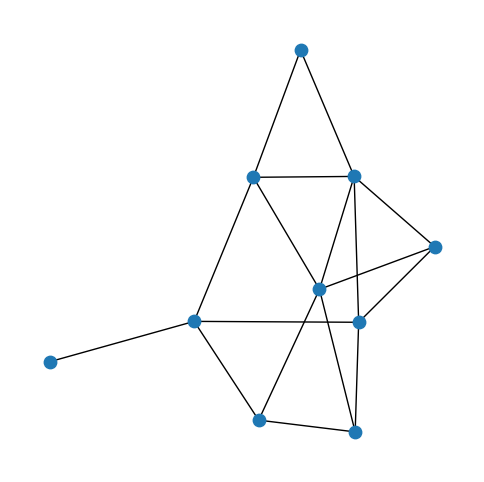

In [9]:
seed = 42
vertices2 = 10
random.seed(seed)
G = nx.gnp_random_graph(vertices2, 0.30, seed, directed=False)
pos = nx.spring_layout(G)

fig_size = 6
plt.figure(figsize=(fig_size, fig_size))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_size=80)
plt.axis("off")
plt.show()

{0: 6, 1: 7, 2: 3, 3: 5, 4: 2, 5: 9, 6: 1, 7: 0, 8: 8, 9: 4}


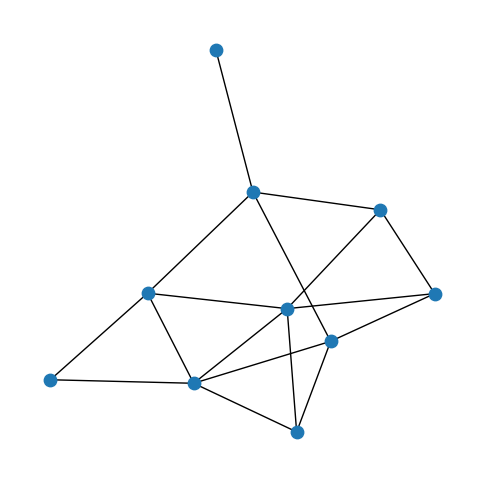

In [12]:
mapping = dict(zip(G.nodes(), sorted(G.nodes(), key=lambda k: random.random())))
print(mapping)
G2 = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(G2)

fig_size = 6
plt.figure(figsize=(fig_size, fig_size))
nx.draw_networkx_edges(G2, pos)
nx.draw_networkx_nodes(G2, pos, node_size=80)
plt.axis("off")
plt.show()